In [15]:
from one.api import ONE
from brainbox.io.one import SpikeSortingLoader
from ibllib.atlas import AllenAtlas
from brainbox.core import TimeSeries
from brainbox.processing import bin_spikes

# import jax.random
from vlgpax.model import Session
from vlgpax.kernel import RBF, RFF
from vlgpax import vi
from einops import rearrange
from sklearn.preprocessing import StandardScaler

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import random
# import math

## EDA

In [16]:
pw = 'international'
one = ONE(base_url='https://openalyx.internationalbrainlab.org', password=pw, silent=True, cache_dir=r'C:\Aryan\4th Year\Winter\DSC 180B\DSC180B-Quarter-2-Project\data\raw\ONE', mode='local')
# ba = AllenAtlas()
pid = '73ff4936-8cd3-4a75-a772-f563e67d249d'
eid = 'ebe2efe3-e8a1-451a-8947-76ef42427cc9' # one.pid2eid(pid)[0]

In [ ]:
eid

: 

In [ ]:
import os

: 

In [ ]:
os.getcwd() # C:\Aryan\4th Year\Winter\DSC 180B\DSC180B-Quarter-2-Project\data\raw

: 

: 

In [17]:
# sl = SpikeSortingLoader(pid=pid, one=one, atlas=ba)
# sl = SpikeSortingLoader(eid=eid, one=one)
sl = SpikeSortingLoader(one=one, eid=eid, pname='probe00')
# sl = SpikeSortingLoader(session_path="C:/Aryan4th Year/Winter/DSC 180B/DSC180B-Quarter-2-Project/data/raw/ONE/angelakilab/", one=one)
spikes, clusters, channels = sl.load_spike_sorting()
clusters = sl.merge_clusters(spikes, clusters, channels)
trials = one.load_object(eid, 'trials', collection='alf')

In [ ]:
sl.download_spike_sorting(path="C:\\Users\\asing\\Downloads\\")

: 

In [ ]:
sl.raster(spikes, channels)

: 

### Data Cleaning
1) Filter data for only good clusters (should indicate single neurons), and for brain regions MOp and MOs
2) Group spikes by neurons
3) Split data across trials
4) Bin spike times for each neuron, for each trial

In [18]:
# good_clusterIDs = clusters['cluster_id'][((clusters['label'] == 1) & ([True if "MO" in s else False for s in clusters['acronym']]))] # Find good clusters that are in MOp and MOs
# good_clusterIDs = clusters['cluster_id'][clusters['label'] == 1] # Find good clusters that are in MOp and MOs
good_clusterIDs = clusters['cluster_id'][((clusters['label'] > 0.5) & ([True if "MO" in s else False for s in clusters['acronym']]))] # Find good clusters that are in MOp and MOs
good_cluster_loc = np.isin(spikes['clusters'], good_clusterIDs) 

In [19]:
good_spikes = {}
for i in spikes:
    good_spikes[i] = spikes[i][good_cluster_loc]

In [ ]:
sl.raster(good_spikes, channels)

: 

In [ ]:
np.unique(trials['choice'])

: 

In [ ]:
np.unique(trials['feedbackType'])

: 

In [20]:
bin_size = 50e-3 # in milliseconds
# min_bins = max(int((60e-3 / bin_size)), 20)
max_trial_type = 40 # Maximum number of trials of each trial type

In [21]:
# good_spikes
# All trials must have the same number of neurons
df = pd.DataFrame(data = {'clusters':good_spikes['clusters'], 'times':good_spikes['times']})
df = df.groupby('clusters')['times'].apply(np.array)

Implementation with bins as a fixed size:

In [ ]:
# trials_spikes = [] # The Spike times and results of each trial

# for i in range(len(trials['goCueTrigger_times'])):
#     spike_range = {}
    
#     spike_range['goCue_times'] = trials['goCue_times'][i]
#     spike_range['firstMovement_times'] = trials['firstMovement_times'][i]
#     spike_range['choice'] = trials['choice'][i]
#     spike_range['feedbackType'] = trials['feedbackType'][i]
    
#     x = []
#     try:
#         hist_bins = np.arange(trials['goCueTrigger_times'][i], trials['firstMovement_times'][i], bin_size)
#     except:
#         continue
#         # the hist bins throw an error if the go cute or first movement time is NaN
#         # print(trials['goCueTrigger_times'][i], trials['firstMovement_times'][i])
    
#     if len(hist_bins) <= min_bins: # Mouse must have a minimum reaction time of 60 ms to be considered a good trial
#         continue
    
#     for j in df: # Iterate through spike times of each cluster
#         inds = ((j>trials['goCueTrigger_times'][i]) & (j<=trials['firstMovement_times'][i])) # From go queue to first movement
#         # print(np.histogram(j[inds], hist_bins)[0])
#         x.append(np.histogram(j[inds], hist_bins)[0])
    
#     spikes_df = pd.DataFrame(x, index=df.index)
#     spike_range['spikes_df'] = spikes_df
    
#     trials_spikes.append(spike_range)

: 

Implementation with a set number of bins instead of bin size:

In [ ]:
# trials_spikes = [] # The Spike times and results of each trial

# for i in range(len(trials['goCueTrigger_times'])):
#     spike_range = {}
    
#     spike_range['goCue_times'] = trials['goCue_times'][i]
#     spike_range['firstMovement_times'] = trials['firstMovement_times'][i]
#     spike_range['choice'] = trials['choice'][i]
#     spike_range['feedbackType'] = trials['feedbackType'][i]
    
#     x = []
    
#     time_range = (trials['firstMovement_times'][i] - trials['goCue_times'][i])
#     if ((time_range < 0.10) | (time_range > 0.300)): # Mouse must have a minimum reaction time of 60 ms to be considered a good trial. We also exlude trials longer than 300 ms because they will have too many spikes per bin
#         continue
    
#     for j in df: # Iterate through spike times of each cluster
#         inds = ((j>trials['goCueTrigger_times'][i]) & (j<=trials['firstMovement_times'][i])) # From go queue to first movement
#         # print(np.histogram(j[inds], hist_bins)[0])
#         x.append(np.histogram(j[inds], 200)[0]) # 200 bins
    
#     spikes_df = pd.DataFrame(x, index=df.index)
#     spike_range['spikes_df'] = spikes_df
    
#     trials_spikes.append(spike_range)

: 

Implementation with bins starting 100ms before first movement to 300 ms after first movement

In [68]:
trials_spikes = [] # The Spike times and results of each trial

for i in range(len(trials['goCueTrigger_times'])):
    if (trials['firstMovement_times'][i] < trials['goCue_times'][i]+0.05):
        continue
    
    spike_range = {}
    
    spike_range['goCue_times'] = trials['goCue_times'][i]
    spike_range['firstMovement_times'] = trials['firstMovement_times'][i]
    spike_range['choice'] = trials['choice'][i]
    spike_range['feedbackType'] = trials['feedbackType'][i]
    
    x = []
    try:
        hist_bins = np.arange(trials['firstMovement_times'][i]-0.1, trials['firstMovement_times'][i]+1.00001, bin_size)
        # print(len(hist_bins))
    except:
        continue
        # the hist bins throw an error if the go cue or first movement time is NaN
        # print(trials['goCueTrigger_times'][i], trials['firstMovement_times'][i])
    
    
    for j in df: # Iterate through spike times of each cluster
        inds = ((j>(trials['firstMovement_times'][i]-0.1)) & (j<=(trials['firstMovement_times'][i]+1.00001))) # From go queue to first movement
        # print(np.histogram(j[inds], hist_bins)[0])
        x.append(np.histogram(j[inds], hist_bins)[0])
    
    spikes_df = pd.DataFrame(x, index=df.index)
    spike_range['spikes_df'] = spikes_df
    
    trials_spikes.append(spike_range)

In [ ]:
random.shuffle(trials_spikes) # Randomize list before splitting into training and testing data

: 

In [13]:
np.array(training_trials[0]['spikes_df']).shape

(58, 22)

In [53]:
len(trials_spikes)

377

In [ ]:
training_trials = []
testing_trials = []


trial_counts = {"correct_left" : [0, 0],  # [training count, testing count]
                "correct_right" : [0, 0],
                "incorrect_left" : [0, 0], # incorrect left means that the mouse chose left, and it was incorrect
                "incorrect_right": [0, 0]}

for i in trials_spikes:
    if ((i["choice"]==-1) & (i["feedbackType"]==1)):
        if trial_counts['correct_left'][0] < max_trial_type:
            training_trials.append(i)
            trial_counts['correct_left'][0] += 1
        elif trial_counts['correct_left'][1] < max_trial_type:
            testing_trials.append(i)
            trial_counts['correct_left'][1] += 1
        else:
            continue
    elif ((i["choice"]==1) & (i["feedbackType"]==1)):
        if trial_counts['correct_right'][0] < max_trial_type:
            training_trials.append(i)
            trial_counts['correct_right'][0] += 1
        elif trial_counts['correct_right'][1] < max_trial_type:
            testing_trials.append(i)
            trial_counts['correct_right'][1] += 1
        else:
            continue
    elif ((i["choice"]==-1) & (i["feedbackType"]==-1)):
        if trial_counts['incorrect_left'][0] < max_trial_type:
            training_trials.append(i)
            trial_counts['incorrect_left'][0] += 1
        elif trial_counts['incorrect_left'][1] < max_trial_type:
            testing_trials.append(i)
            trial_counts['incorrect_left'][1] += 1
        else:
            continue
    elif ((i["choice"]==1) & (i["feedbackType"]==-1)):
        if trial_counts['incorrect_right'][0] < max_trial_type:
            training_trials.append(i)
            trial_counts['incorrect_right'][0] += 1
        elif trial_counts['incorrect_right'][1] < max_trial_type:
            testing_trials.append(i)
            trial_counts['incorrect_right'][1] += 1
        else:
            continue

: 

In [69]:
training_trials = trials_spikes[:250]
testing_trials = trials_spikes[250:]

In [ ]:
len(training_trials)

: 

In [ ]:
training_trials[40]['spikes_df'].T

: 

In [70]:
session = Session(bin_size)
for i, trial in enumerate(training_trials):
    session.add_trial(i, y=trial['spikes_df'].T)

In [71]:
length_scale = 0.200 # in seconds
kernel = RBF(scale=1, lengthscale=length_scale)

In [72]:
session, params = vi.fit(session, n_factors=2, kernel=kernel, seed=10, max_iter=2, trial_length=20, GPFA=True)

Initializing
Initialized


c:\Users\asing\anaconda3\envs\production\lib\site-packages\vlgpax\vi.py:267: UserWarning:

M: loss increased

c:\Users\asing\anaconda3\envs\production\lib\site-packages\vlgpax\vi.py:160: UserWarning:

E: loss increased



EM Iteration 1, 	Loss = 25.0217, 	M step: 3.68s, 	E step: 19.11s
EM Iteration 2, 	Loss = 24.7205, 	M step: 2.36s, 	E step: 18.07s
Inferring


TypeError: Incompatible shapes for arguments to triangular_solve: (2, 30, 30) and (2, 29, 1).

In [ ]:
# trials_spikes[2]['spikes_df'].T.to_csv("neural_data.csv")

: 

In [ ]:
# Find testing trajectories
sessionTest = Session(bin_size)
for i, trial in enumerate(testing_trials):
    sessionTest.add_trial(i, y=trial['spikes_df'].T)

sessionTest = vi.infer(sessionTest, params=params, )
z_test = rearrange(sessionTest.z, '(trials time) lat -> trials time lat', time=testing_trials[0]['spikes_df'].shape[1])

Trial 0, 	Loss = 11.5244
Trial 1, 	Loss = 19.6705
Trial 2, 	Loss = 13.1155
Trial 3, 	Loss = 14.9104
Trial 4, 	Loss = 15.0209


c:\Users\asing\anaconda3\envs\production\lib\site-packages\vlgpax\vi.py:160: UserWarning:

E: loss increased



Trial 5, 	Loss = 17.0151
Trial 6, 	Loss = 13.2794
Trial 7, 	Loss = 11.4648
Trial 8, 	Loss = 13.5928
Trial 9, 	Loss = 19.4956
Trial 10, 	Loss = 16.4380
Trial 11, 	Loss = 16.2744
Trial 12, 	Loss = 15.7452
Trial 13, 	Loss = 17.3525


c:\Users\asing\anaconda3\envs\production\lib\site-packages\vlgpax\vi.py:170: UserWarning:

E: maximum number of iterations reached



Trial 14, 	Loss = 19.8861
Trial 15, 	Loss = 17.9603
Trial 16, 	Loss = 16.3297
Trial 17, 	Loss = 20.0420
Trial 18, 	Loss = 17.2589
Trial 19, 	Loss = 17.4385
Trial 20, 	Loss = 16.8834
Trial 21, 	Loss = 18.7135
Trial 22, 	Loss = 17.8033
Trial 23, 	Loss = 14.8912
Trial 24, 	Loss = 19.1266
Trial 25, 	Loss = 21.1840
Trial 26, 	Loss = 17.3683
Trial 27, 	Loss = 20.9825
Trial 28, 	Loss = 16.2683
Trial 29, 	Loss = 20.1825
Trial 30, 	Loss = 18.9499
Trial 31, 	Loss = 21.5778
Trial 32, 	Loss = 16.4618
Trial 33, 	Loss = 20.1181
Trial 34, 	Loss = 15.8100
Trial 35, 	Loss = 19.3599
Trial 36, 	Loss = 14.2228
Trial 37, 	Loss = 15.1773
Trial 38, 	Loss = 15.4787
Trial 39, 	Loss = 19.1218
Trial 40, 	Loss = 20.0849
Trial 41, 	Loss = 19.1307
Trial 42, 	Loss = 16.1028
Trial 43, 	Loss = 17.4708
Trial 44, 	Loss = 17.6968
Trial 45, 	Loss = 19.5601
Trial 46, 	Loss = 19.2584
Trial 47, 	Loss = 22.4519
Trial 48, 	Loss = 15.7116
Trial 49, 	Loss = 17.3012
Trial 50, 	Loss = 18.6130
Trial 51, 	Loss = 16.0757
Trial 52, 	L

: 

### Plot training trajectories and add them to test set. Plot test trajectories after


In [ ]:
len(np.arange(-0.1, 1, 0.05))

: 

In [48]:
import plotly.graph_objects as go

In [32]:
np.array(z_test).shape

(138, 22, 2)

In [ ]:
z_train = rearrange(session.z, '(trials time) lat -> trials time lat', time=training_trials[0]['spikes_df'].shape[1])

first = True
first2= True
time_sig = 4
X_class_train = []
y_class_train = []
time_bins = len(z_train[i][:, 0])

fig = go.Figure()
for i in range(len(z_train)):
    if ((training_trials[i]['choice']==1) & (training_trials[i]['feedbackType']==1)):
        if first:
            fig.add_trace(go.Scatter3d(x=np.arange(-450, 1000, 50), y=z_train[i][:, 0], z=z_train[i][:, 1],
                      mode='lines', line={'color':'blue', 'width':1}, legendgroup='right', name='Wheel Turned Right', showlegend=True))
            first = False
        else:
            fig.add_trace(go.Scatter3d(x=np.arange(-450, 1000, 50), y=z_train[i][:, 0], z=z_train[i][:, 1],
                        mode='lines', line={'color':'blue', 'width':1}, legendgroup='right', showlegend=False))
        # fig.add_scatter3d(x=[time_sig], y=z_train[i][time_sig:time_sig+1, 0], z=z_train[i][time_sig:time_sig+1, 1], mode='markers', marker={'color':'green', 'size':5})  # show point of significance
        X_class_train.append(z_train[i][time_sig]); y_class_train.append(0)
        
    elif ((training_trials[i]['choice']==-1) & (training_trials[i]['feedbackType']==1)):
        if first2:
            fig.add_trace(go.Scatter3d(x=np.arange(-450, 1000, 50), y=z_train[i][:, 0], z=z_train[i][:, 1],
                      mode='lines', line={'color':'red', 'width':1}, legendgroup='left', name='Wheel Turned Left', showlegend=True))
            first2 = False
        else:
            fig.add_trace(go.Scatter3d(x=np.arange(-450, 1000, 50), y=z_train[i][:, 0], z=z_train[i][:, 1],
                        mode='lines', line={'color':'red', 'width':1}, legendgroup='left', showlegend=False))
        # fig.add_scatter3d(x=[time_sig], y=z_train[i][time_sig:time_sig+1, 0], z=z_train[i][time_sig:time_sig+1, 1], mode='markers', marker={'color':'black', 'size':5})  # show point of significance
        X_class_train.append(z_train[i][time_sig]); y_class_train.append(1)
        
    elif ((training_trials[i]['choice']==1) & (training_trials[i]['feedbackType']==-1)):
        # if first:
        #     fig = px.line_3d(x=np.arange(-0.1, 1, 0.05), y=z_test[i][:, 0], z=z_test[i][:, 1], color=["green"]*time_bins, width=800, height=800)
        #     first = False
        # else:
        #     fig.add_scatter3d(x=np.arange(-0.1, 1, 0.05), y=z_test[i][:, 0], z=z_test[i][:, 1], mode='lines', line={'color':"green"}, opacity=0.5)
        X_class_train.append(z_train[i][time_sig]); y_class_train.append(2)
        
    elif ((training_trials[i]['choice']==-1) & (training_trials[i]['feedbackType']==-1)):
        # if first:
        #     fig = px.line_3d(x=np.arange(-0.1, 1, 0.05), y=z_test[i][:, 0], z=z_test[i][:, 1], color=["black"]*time_bins, width=800, height=800)
        #     first = False
        # else:
        #     fig.add_scatter3d(x=np.arange(-0.1, 1, 0.05), y=z_test[i][:, 0], z=z_test[i][:, 1], mode='lines', line={'color':"black"}, opacity=1)
        X_class_train.append(z_train[i][time_sig]); y_class_train.append(3)
        

X_class_test = []
y_class_test = []

# Plot testing trajectories
for i in range(len(z_test)):
    if ((testing_trials[i]['choice']==1) & (testing_trials[i]['feedbackType']==1)):
        # if first:
        #     fig = px.line_3d(x=np.arange(time_bins), y=z_test[i][:, 0], z=z_test[i][:, 1], color=["green"]*time_bins, width=800, height=800)
        #     first = False
        # else:
        #     fig.add_scatter3d(x=np.arange(time_bins), y=z_test[i][:, 0], z=z_test[i][:, 1], mode='lines', line={'color':"green"}, opacity=0.5)
        # fig.add_scatter3d(x=[time_sig], y=z_train[i][time_sig:time_sig+1, 0], z=z_train[i][time_sig:time_sig+1, 1], mode='markers', marker={'color':'green', 'size':5})  # show point of significance
        X_class_test.append(z_test[i][time_sig]); y_class_test.append(0)
        
    elif ((testing_trials[i]['choice']==-1) & (testing_trials[i]['feedbackType']==1)):
        # if first:
        #     fig = px.line_3d(x=np.arange(time_bins), y=z_test[i][:, 0], z=z_test[i][:, 1], color=["black"]*time_bins, width=800, height=800)
        #     first = False
        # else:
        #     fig.add_scatter3d(x=np.arange(time_bins), y=z_test[i][:, 0], z=z_test[i][:, 1], mode='lines', line={'color':"black"}, opacity=0.5)
        # fig.add_scatter3d(x=[time_sig], y=z_train[i][time_sig:time_sig+1, 0], z=z_train[i][time_sig:time_sig+1, 1], mode='markers', marker={'color':'black', 'size':5})  # show point of significance
        X_class_test.append(z_test[i][time_sig]); y_class_test.append(1)
        
    elif ((testing_trials[i]['choice']==1) & (testing_trials[i]['feedbackType']==-1)):
        X_class_test.append(z_test[i][time_sig]); y_class_test.append(2)
        
    elif ((testing_trials[i]['choice']==-1) & (testing_trials[i]['feedbackType']==-1)):
        X_class_test.append(z_test[i][time_sig]); y_class_test.append(3)

X_class_train = np.array(X_class_train)
y_class_train = np.array(y_class_train)
X_class_test = np.array(X_class_test)
y_class_test = np.array(y_class_test)

fig.update_layout(scene = dict(
                    xaxis_title='Time (ms)',
                    yaxis_title='Latent Variable 1',
                    zaxis_title='Latent Variable 2'),
                    width=1000, height=1000, title='Latent Variables over Time'
                    )
fig.show()

In [40]:
fig.write_html(r"C:\Aryan\4th Year\Winter\DSC 180B\DSC180B-Quarter-2-Project\output\mouse1\latent_trajs2_vlgp.html")

In [49]:
z_train = rearrange(session.z, '(trials time) lat -> trials time lat', time=training_trials[0]['spikes_df'].shape[1])

first = True
first2= True
time_sig = 4
X_class_train = []
y_class_train = []
time_bins = len(z_train[i][:, 0])

fig = go.Figure()
for i in range(len(z_train)):
    if ((training_trials[i]['choice']==1) & (training_trials[i]['feedbackType']==1)):
        if first:
            fig.add_trace(go.Scatter3d(x=z_train[i][:, 0], y=z_train[i][:, 1], z=z_train[i][:, 2],
                      mode='lines', line={'color':'blue', 'width':1}, legendgroup='right', name='Wheel Turned Right', showlegend=True))
            first = False
        else:
            fig.add_trace(go.Scatter3d(x=z_train[i][:, 0], y=z_train[i][:, 1], z=z_train[i][:, 2],
                        mode='lines', line={'color':'blue', 'width':1}, legendgroup='right', showlegend=False))
        # fig.add_scatter3d(x=[time_sig], y=z_train[i][time_sig:time_sig+1, 0], z=z_train[i][time_sig:time_sig+1, 1], mode='markers', marker={'color':'green', 'size':5})  # show point of significance
        X_class_train.append(z_train[i][time_sig]); y_class_train.append(0)
        
    elif ((training_trials[i]['choice']==-1) & (training_trials[i]['feedbackType']==1)):
        if first2:
            fig.add_trace(go.Scatter3d(x=z_train[i][:, 0], y=z_train[i][:, 1], z=z_train[i][:, 2],
                      mode='lines', line={'color':'red', 'width':1}, legendgroup='left', name='Wheel Turned Left', showlegend=True))
            first2 = False
        else:
            fig.add_trace(go.Scatter3d(x=z_train[i][:, 0], y=z_train[i][:, 1], z=z_train[i][:, 2],
                        mode='lines', line={'color':'red', 'width':1}, legendgroup='left', showlegend=False))
        # fig.add_scatter3d(x=[time_sig], y=z_train[i][time_sig:time_sig+1, 0], z=z_train[i][time_sig:time_sig+1, 1], mode='markers', marker={'color':'black', 'size':5})  # show point of significance
        X_class_train.append(z_train[i][time_sig]); y_class_train.append(1)
        
    elif ((training_trials[i]['choice']==1) & (training_trials[i]['feedbackType']==-1)):
        # if first:
        #     fig = px.line_3d(x=np.arange(-0.1, 1, 0.05), y=z_test[i][:, 0], z=z_test[i][:, 1], color=["green"]*time_bins, width=800, height=800)
        #     first = False
        # else:
        #     fig.add_scatter3d(x=np.arange(-0.1, 1, 0.05), y=z_test[i][:, 0], z=z_test[i][:, 1], mode='lines', line={'color':"green"}, opacity=0.5)
        X_class_train.append(z_train[i][time_sig]); y_class_train.append(2)
        
    elif ((training_trials[i]['choice']==-1) & (training_trials[i]['feedbackType']==-1)):
        # if first:
        #     fig = px.line_3d(x=np.arange(-0.1, 1, 0.05), y=z_test[i][:, 0], z=z_test[i][:, 1], color=["black"]*time_bins, width=800, height=800)
        #     first = False
        # else:
        #     fig.add_scatter3d(x=np.arange(-0.1, 1, 0.05), y=z_test[i][:, 0], z=z_test[i][:, 1], mode='lines', line={'color':"black"}, opacity=1)
        X_class_train.append(z_train[i][time_sig]); y_class_train.append(3)
        

X_class_test = []
y_class_test = []

# Plot testing trajectories
for i in range(len(z_test)):
    if ((testing_trials[i]['choice']==1) & (testing_trials[i]['feedbackType']==1)):
        # if first:
        #     fig = px.line_3d(x=np.arange(time_bins), y=z_test[i][:, 0], z=z_test[i][:, 1], color=["green"]*time_bins, width=800, height=800)
        #     first = False
        # else:
        #     fig.add_scatter3d(x=np.arange(time_bins), y=z_test[i][:, 0], z=z_test[i][:, 1], mode='lines', line={'color':"green"}, opacity=0.5)
        # fig.add_scatter3d(x=[time_sig], y=z_train[i][time_sig:time_sig+1, 0], z=z_train[i][time_sig:time_sig+1, 1], mode='markers', marker={'color':'green', 'size':5})  # show point of significance
        X_class_test.append(z_test[i][time_sig]); y_class_test.append(0)
        
    elif ((testing_trials[i]['choice']==-1) & (testing_trials[i]['feedbackType']==1)):
        # if first:
        #     fig = px.line_3d(x=np.arange(time_bins), y=z_test[i][:, 0], z=z_test[i][:, 1], color=["black"]*time_bins, width=800, height=800)
        #     first = False
        # else:
        #     fig.add_scatter3d(x=np.arange(time_bins), y=z_test[i][:, 0], z=z_test[i][:, 1], mode='lines', line={'color':"black"}, opacity=0.5)
        # fig.add_scatter3d(x=[time_sig], y=z_train[i][time_sig:time_sig+1, 0], z=z_train[i][time_sig:time_sig+1, 1], mode='markers', marker={'color':'black', 'size':5})  # show point of significance
        X_class_test.append(z_test[i][time_sig]); y_class_test.append(1)
        
    elif ((testing_trials[i]['choice']==1) & (testing_trials[i]['feedbackType']==-1)):
        X_class_test.append(z_test[i][time_sig]); y_class_test.append(2)
        
    elif ((testing_trials[i]['choice']==-1) & (testing_trials[i]['feedbackType']==-1)):
        X_class_test.append(z_test[i][time_sig]); y_class_test.append(3)

X_class_train = np.array(X_class_train)
y_class_train = np.array(y_class_train)
X_class_test = np.array(X_class_test)
y_class_test = np.array(y_class_test)

fig.update_layout(scene = dict(
                    xaxis_title='Latent Variable 1',
                    yaxis_title='Latent Variable 2',
                    zaxis_title='Latent Variable 3'),
                    width=1000, height=1000, title='Latent Variables'
                    )
fig.show()

In [50]:
fig.write_html(r"C:\Aryan\4th Year\Winter\DSC 180B\DSC180B-Quarter-2-Project\output\mouse1\latent_trajs3_vlgp.html")

In [20]:
from sklearn.linear_model import LogisticRegression

mod = LogisticRegression()
mod.fit(X_class_train, y_class_train)
print(mod.score(X_class_train, y_class_train))
mod.score(X_class_test, y_class_test)

0.776


0.7246376811594203

0.9368932038834952
0.970873786407767


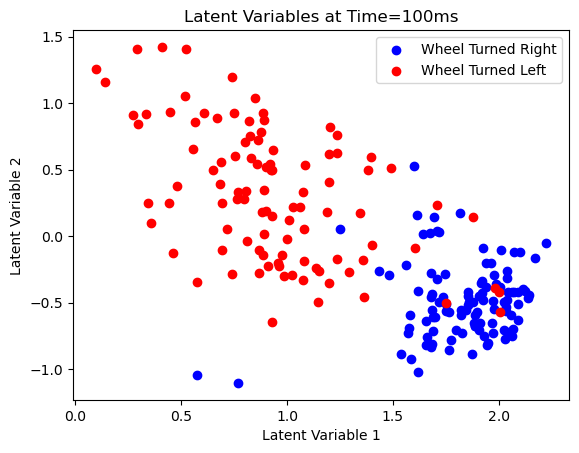

In [81]:
# Predict between Just correct left and correct right
X_class_train01 = X_class_train[((y_class_train==0) | (y_class_train==1))]
y_class_train01 = y_class_train[((y_class_train==0) | (y_class_train==1))]
X_class_test01 = X_class_test[((y_class_test==0) | (y_class_test==1))]
y_class_test01 = y_class_test[((y_class_test==0) | (y_class_test==1))]


mod = LogisticRegression()
mod.fit(X_class_train01, y_class_train01)
print(mod.score(X_class_train01, y_class_train01))
print(mod.score(X_class_test01, y_class_test01))

plt.scatter(X_class_train[y_class_train==0][:, 0], X_class_train[y_class_train==0][:, 1], color='blue', label='Wheel Turned Right')
plt.scatter(X_class_train[y_class_train==1][:, 0], X_class_train[y_class_train==1][:, 1], color='red', label='Wheel Turned Left')
plt.xlabel('Latent Variable 1')
plt.ylabel('Latent Variable 2')
plt.title('Latent Variables at Time=100ms')
plt.legend()

0.8907563025210085
0.8135593220338984


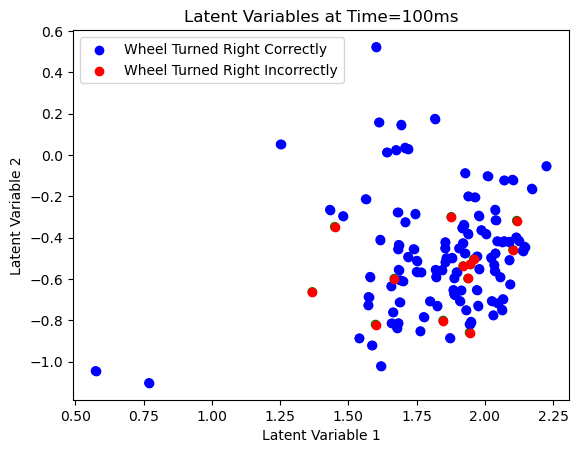

In [83]:
# Predict between Just correct right and incorrect right. Obtains a low accuracy compared to baseline
X_class_train02 = X_class_train[((y_class_train==0) | (y_class_train==2))]
y_class_train02 = y_class_train[((y_class_train==0) | (y_class_train==2))]
X_class_test02 = X_class_test[((y_class_test==0) | (y_class_test==2))]
y_class_test02 = y_class_test[((y_class_test==0) | (y_class_test==2))]


mod = LogisticRegression()
mod.fit(X_class_train02, y_class_train02)
print(mod.score(X_class_train02, y_class_train02))
print(mod.score(X_class_test02, y_class_test02)) # is 1 because the test set is unbalanced

plt.scatter(X_class_train02[:, 0], X_class_train02[:, 1], color=np.array(['blue', 'red', 'green', 'black'])[y_class_train02])
plt.scatter(X_class_train[y_class_train==0][:, 0], X_class_train[y_class_train==0][:, 1], color='blue', label='Wheel Turned Right Correctly')
plt.scatter(X_class_train[y_class_train==2][:, 0], X_class_train[y_class_train==2][:, 1], color='red', label='Wheel Turned Right Incorrectly')
plt.xlabel('Latent Variable 1')
plt.ylabel('Latent Variable 2')
plt.title('Latent Variables at Time=100ms')
plt.legend()

0.8978102189781022
0.8333333333333334


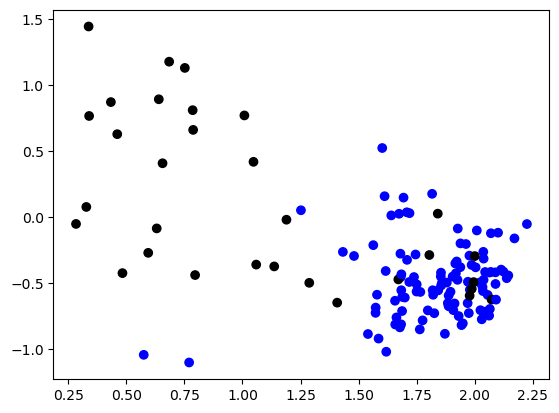

In [23]:
# Predict between correct left and incorrect right
X_class_train03 = X_class_train[((y_class_train==0) | (y_class_train==3))]
y_class_train03 = y_class_train[((y_class_train==0) | (y_class_train==3))]
X_class_test03 = X_class_test[((y_class_test==0) | (y_class_test==3))]
y_class_test03 = y_class_test[((y_class_test==0) | (y_class_test==3))]


mod = LogisticRegression()
mod.fit(X_class_train03, y_class_train03)
print(mod.score(X_class_train03, y_class_train03))
print(mod.score(X_class_test03, y_class_test03))

plt.scatter(X_class_train03[:, 0], X_class_train03[:, 1], color=np.array(['blue', 'red', 'green', 'black'])[y_class_train03])